In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statistics
import io
import PIL
from PIL import Image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2

In [33]:
class IMDB(Dataset):
    def __init__(self, URL: str = "https://www.imdb.com/chart/top-english-movies", IMG_SIZE: tuple = (44,64)):
        self.URL = URL
        self.IMG_SIZE = IMG_SIZE
        page = requests.get(URL)
        soup = BeautifulSoup(page.content, 'html.parser')
        movie_list = soup.find(class_='lister-list')
        movie_elems = movie_list.find_all('tr')
    
        movTitle = []
        movYear = []
        movRating = []
        movPoster = []

        for elm in movie_elems:
            title = elm.find('td', 'titleColumn').a['title']
            movTitle.append(title)
            year = int(elm.find('td', 'titleColumn').span.string[1:-1])
            movYear.append(year)
            rating = float(elm.find('td', 'ratingColumn imdbRating').strong.string)
            movRating.append(rating)
            posterURL = elm.find('td', 'posterColumn').a.img['src']
            data = requests.get(posterURL).content
            img = Image.open(io.BytesIO(data)).resize(IMG_SIZE)
            array = np.array(img, dtype='int64')
            movPoster.append(array)

        imdb = {'Movie Title':movTitle, 'Year Published':movYear, 'IMDb Rating':movRating, 'Movie Poster': movPoster}
        self.df = pd.DataFrame(imdb)


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, index:int) -> np.ndarray:
        image = self.df['Movie Poster'][index].reshape(3, *self.IMG_SIZE).astype('float32')
        return image
    
    def displayImage(self, index:int):
        image = self.df['Movie Poster'][index]
        plt.imshow(image)


imdbDataset = IMDB()
imdbDataset.displayImage(0)

In [35]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

#Instantiate the model
model = ConvAutoencoder()

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [37]:
train_loader = DataLoader(
    imdbDataset,
    batch_size=10,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

In [38]:
#Epochs
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images in train_loader:
        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [ ]:
#Batch of test images
dataiter = iter(train_loader)
images = dataiter.next()
images = images.cuda()

#Sample outputs
output = model(images)
images = images.cpu().data.numpy()
output = output.view(train_loader.batch_size, 3, *IMG_SIZE)
output = output.cpu().data.numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].reshape(*IMG_SIZE, 3).astype('int64'))
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx].reshape(*IMG_SIZE, 3).astype('int64'))
plt.show()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

IMDb_df.plot.scatter("Year Published", "IMDb Rating", ax=ax1)

lr = LinearRegression().fit(np.array(IMDb_df['Year Published']).reshape(-1,1), np.array(IMDb_df['IMDb Rating']).reshape(-1,1))
IMDb_df.plot.scatter(x='Year Published', y='IMDb Rating', ax=ax2)
ax2.plot(np.array(IMDb_df['Year Published']) , lr.predict(np.array(IMDb_df['Year Published']).reshape(-1,1)), color = 'r')
plt.subplots_adjust(right=1.656)

plt.show()

In [ ]:
# #def getMetaCritic(URL):

# movie_list = soup.find(class_='clamp-list')

# movie_elems = movie_list.find_all('tr')

# page = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

# webpage = urlopen(page).read()

# soup = BeautifulSoup(webpage, "html.parser")

 

# for elm in movie_elems:
#   try:
#     title = elm.find('td', 'clamp-summary-wrap').find('a', "title").h3.string
#     movTitle.append(title)
#     year = int(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-details').span.string[-4:])
#     movYear.append(year)
#     rating = float(elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string)
#     movRating.append(rating)
#   except AttributeError:
#     continue

# meta = {'Movie Title':movTitle, 'Year Published':movYear, 'Metacritic Rating':movRating}
# pd.DataFrame(meta) #Add Return when converted into Function


# elm.find('td', 'clamp-summary-wrap').find('div', 'clamp-score-wrap').a.div.string

In [10]:
x = [1,-2,5] 
y = [1,-2,5]
y_bar = sum(y)/len(y) #8.1
x_bar = sum(x)/len(x) #1973.33

In [11]:
tot = 0
for x_val,y_val in zip(x,y):
  x_var = (x_val - x_bar)* -1
  y_var = (y_val - y_bar)* -1
  tot += x_var * y_var
tot/len(x)

8.222222222222221

In [12]:
np.dot((np.array(x) - np.average(x)),(np.array(y) - np.average(y)))/np.array(x).shape[0]

8.222222222222221

In [13]:
a = np.ones((4,7)) + 4

In [14]:
b = np.ones((3,4)) /2

In [15]:
np.dot(b, a)

array([[10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10., 10., 10.]])

In [16]:
x = np.array([1, 5, 4, 7])
y = x * 5 + 7

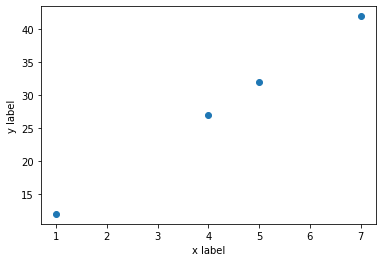

In [17]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.show()

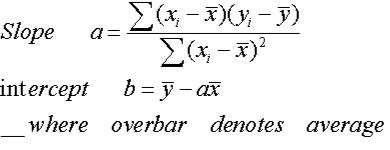

In [18]:
a_numer = np.dot(x - np.average(x), y - np.average(y))
a_denom = np.dot(x - np.average(x), x - np.average(x))

In [19]:
a = a_numer/a_denom

In [20]:
b = np.average(y) - a * np.average(x)

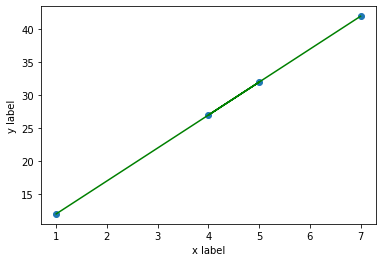

In [21]:
fig, ax = plt.subplots()
ax.scatter([1, 5, 4, 7], [12, 32, 27, 42])
ax.set_ylabel("y label")
ax.set_xlabel('x label')
plt.plot(x, a*x + b,'g-')
plt.show()

In [22]:
scaler = StandardScaler()
scaler.fit(x.reshape(-1, 1))
scaler.transform(x.reshape(-1, 1))

array([[-1.5011107 ],
       [ 0.34641016],
       [-0.11547005],
       [ 1.27017059]])

In [23]:
class Perceptron:

    def __init__(self, no_of_inputs, threshold=100, learning_rate=0.01):
        self.threshold = threshold
        self.learning_rate = learning_rate
        self.weights = np.zeros(no_of_inputs + 1)
           
    def predict(self, inputs):
        summation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        if summation > 0:
          activation = 1
        else:
          activation = 0            
        return activation

    def train(self, training_inputs, labels):
        for _ in range(self.threshold):
            for inputs, label in zip(training_inputs, labels):
                prediction = self.predict(inputs)
                self.weights[1:] += self.learning_rate * (label - prediction) * inputs
                self.weights[0] += self.learning_rate * (label - prediction)

In [24]:
listy = [1,2,3]
listx = [3,2,1,0]
for x in zip(listx,listy):
  print(x)

(3, 1)
(2, 2)
(1, 3)


In [25]:
myPerceptron = Perceptron(4)

In [26]:
[(3,1), (2,2), (1,3)]

[(3, 1), (2, 2), (1, 3)]

In [27]:
 summation = np.dot(np.zeros((2,4)), myPerceptron.weights[1:]) + myPerceptron.weights[0]